# Unbinned RL deconvolution

## Intro

Toy example of an unbnined Richardson-Lucy deconvolution.

Section "coordinates" has an explanation about a different parametriztion of the response for describe the CDS. This is a way to decouple the binning of the response with the binning of the data. It should work also for a binned analysis, but I think it's only efficient in the case of the unbinned.

Section "Simulations and Response generator" described how the response is constructed. A lot of this will be replaced by MEGAlib. I used some simple functions here to demostrate the method, but the algorith does not depend on the functions being simple nor analytic.

Section "Richardson-Lucy deconvolution" is the meat of this notebook. There is an explanation there abou moving from a binned to an unbinned analysis. It also has a way to fit the bkg that I think will be an improvement also for the binned case.

Finally, the "Analysis" section run an event-by-event simulation and reconstructs the image.

The whole notebook takes 2-3 min to run

## Imports

In [1]:
from histpy import Axis, HealpixAxis, Axes, Histogram
from astropy.coordinates import SkyCoord
import astropy.units as u
from scoords import SpacecraftFrame
from scipy.stats.sampling import TransformedDensityRejection, SimpleRatioUniforms, NumericalInverseHermite, NumericalInversePolynomial
import matplotlib.pyplot as plt

from scipy.stats import norm, lognorm, truncnorm, vonmises
import numpy as np

from scipy.special import roots_legendre

from mhealpy import HealpixMap
from astropy.coordinates import concatenate as concatenate_skycoords

from scipy.integrate import quad, fixed_quad

from scipy.special import erf, erfi

from scipy.stats import poisson, expon, chi2

import astropy
from astropy.coordinates import concatenate as skycoord_concatenate

from matplotlib.colors import LogNorm
from mhealpy import HealpixBase

## Coordinates

The data is composed of a list of event, each with the regular CDS space information (phi, psichi). 

For simplicity, all the events have the same energy in this example. We also assume for simplicity that the SC orientation is fixed. Note that an unbinned analysis can handle both, it's just a simplification.

For the response, we perform a coordinate transformation in order to facilitate the response interpolation. This decouples the binning of the response with the binning of the data, and reduces the number of bins.

Instead of binning the response in (lonlat, phi, psichi), we bin it in (lonlat, phi, arm, az):
- lonlat: The true location of the source
- phi: the polar scattering angle
- psichi: direction of the scattered gamma ray
- arm: the angular distance between psichi and the closest reconstructed position to the Compton cone. Note that arm is limited toi the range [-phi, pi-phi]
- az: the azimuthal scattering angle

You can go back and forth between psichi, and (arm,az) with the following functions below. Note that you can only do this for the response, not the data, since for the data you don't know the true source location.

In [2]:
def phiaz_to_psichi(skycoord, phi, az):
    """
    Parameters
    ----------
    skycoord: SkyCoord
        True location of the source --i.e. lonlat
    phi: array
        Polar scattering angle (rad)
    az: array
        Azimuthal scattering angle (rad). Clock-wise with respect to the vector return by get_pol_unit_vec() below
    
    Returns
    -------
    psichi: SkyCoord
        Direction of the scattered gamma ray
    """
    
    
    # Transform phi,az to psi,chi
    x,y,z = skycoord.cartesian.xyz
    
    # Reference vector for polarization
    px,py = get_pol_unit_vec(x,y,z)
    
    px = px.transpose()
    py = py.transpose()    
        
    psichi_xyz = (np.sin(phi[:,None]) * (px * np.cos(az[:,None]) + 
                                         py * np.sin(az[:,None])) + 
                  skycoord.cartesian.xyz * np.cos(phi[:,None]))
    
    psichi = SkyCoord(psichi_xyz,
                      representation_type = 'cartesian',
                      frame = SpacecraftFrame())
    psichi.representation_type = 'unitspherical'
    
    return psichi

def psichi_to_phiaz(coord, psichi):
    """
    Parameters
    ----------
    coord: SkyCoord
        True location of the source --i.e. lonlat
    psichi: SkyCoord
        Direction of the scattered gamma ray
    
    Returns
    -------
    phi: array
        Polar scattering angle (rad)
    az: array
        Azimuthal scattering angle (rad). Clock-wise with respect to the vector return by get_pol_unit_vec() below.
    """
    
    psichi_pvec = psichi.cartesian.xyz[:,None,:] - coord.cartesian.xyz[:,:,None]
    
    px,py = get_pol_unit_vec(*coord.cartesian.xyz)
    
    px = px[:,:,None]
    py = py[:,:,None]
    
    #psichi_px = np.tensordot(px, psichi_pvec, axes = ([0],[0]))
    #psichi_py = np.tensordot(py, psichi_pvec, axes = ([0],[0]))
    # There should be a better way to do the dotprod along axis=0. I'll figure it out someday
    psichi_px = np.sum(px*psichi_pvec, axis = 0)
    psichi_py = np.sum(py*psichi_pvec, axis = 0)
    
    az = np.arctan2(psichi_py, psichi_px)
    
    phi = coord[:,None].separation(psichi[None,:]).rad
    
    return phi,az.to_value(u.rad)

def get_pol_unit_vec(x,y,z):
    """
    Compute the reference plane for the azimuthal polar angle.

    See https://ucbssl.slack.com/archives/C02TWC7U4NL/p1678987695343059

    The (x,y,z) direction is normal to he output plan, and the px-axis is chosen to minimize the singularities.

    Parameters
    ----------
    x,y,z: arrays
        Cartesian coordinates of the normalized directions
    
    Return
    ------
    px,py: arrays
        Normalized vector defining a plane normal to (x,y,z). Size (3, N), where N is the number of coordinates
    """
    
    px = np.array([((1+z) - (x**2-y**2)/(1+z))/2, -x*y/(1+z), -x])
    py = np.array([-x*y/(1+z), 1 - y**2/(1+z), -y])

    return px, py

## Simulations and response generation (MEGAlib replacement)

In the real case, this section would be replaced by MEGAlib, so we can include all detector effects.

In [3]:
angres = np.deg2rad(3) # Angular resolution
peak_aeff = 16**2   # On-axis effective area
Ei = 511 # Simulated energy

### Signal (gammas) simulations

#### Event generator

Based on analytics distributions in az, phi and arm defined below.

In [4]:
def random_event(skycoord, nevents):
    """
    
    """
    
    az = Az_dist().rvs(nevents)

    phi = Phi_dist(Ei).rvs(nevents)

    arm = Arm_dist(phi).rvs()
    
    # Transform arm,az to psi,chi
    psichi = phiaz_to_psichi(skycoord, phi + arm, az)
    
    return phi, psichi

class Az_dist:

    def pdf(self, az):
    
        return 1/(2*np.pi)

    def cdf(self, az):

        return az/(2*np.pi)

    def rvs(self, size = None):

        return np.random.uniform(0, 2*np.pi, size = size)

class Phi_dist:
    def __init__(self, Ei):
        self._Ei = np.array(Ei)/511
    
    def pdf(self, phi):
        return self._Ei * np.sin(phi) / (1+self._Ei*(1-np.cos(phi))) / np.log(1+2*self._Ei)
        
    def cdf(self, phi):
        return np.log(1 + self._Ei*(1-np.cos(phi))) / np.log(1+2*self._Ei)
        
        return cdf_phi(phi, self._Ei)

    def _rvs(self, Ei, size = None):
        return SimpleRatioUniforms(self.__class__(Ei*511),
                                   mode = np.arctan(np.sqrt(1+2*(Ei))/(Ei)),
                                   domain = (0,np.pi)).rvs(size)
        
    def rvs(self, size = None):
        if np.isscalar(self._Ei):
            return self._rvs(self._Ei, size)
        else:
            return np.array([self._rvs(e, size) for e in self._Ei])

class Arm_dist:

    def __init__(self, phi):
        self._phi = np.array(phi)

        # normalized such that int_0^pi pdf(arm) darm = 1  (already includes sin(phi+arm))
        
        #Integrate[PDF[TruncatedDistribution[{0,\[Pi]},NormalDistribution [\[Phi],\[Sigma]]], x]Sin[x],{x,0,\[Pi]}]//Re//FullSimplify
        #Mathematica couldn't get only the real part analytically
        self._norm = np.real(
            np.exp(-(angres**2/2)-1j *phi) * 
            (1j *erf((np.pi+1j *angres**2-phi)/(np.sqrt(2) * angres))+
             np.exp(2j *phi) *(erfi((angres**2-1j *phi)/(np.sqrt(2) *angres))-
                              erfi((1j *np.pi+angres**2-1j *phi)/(np.sqrt(2) *angres)))+
             erfi((angres**2+1j *phi)/(np.sqrt(2) *angres)))
                /(2 *(erf(phi/(np.sqrt(2) *angres))-erf((-np.pi+phi)/(np.sqrt(2) *angres)))))
        
    
    def pdf(self, arm):
        phi = self._phi # Convenience
        
        return truncnorm.pdf(arm, -phi/angres, (np.pi-phi)/angres, 0, angres) * np.sin(phi+arm) / self._norm

    def cdf(self, arm):

        if np.isscalar(arm) and np.isscalar(self._phi):
            return quad(self.pdf, -self._phi, arm)[0]
        
        if np.isscalar(self._phi):
            return np.array([self.cdf(a) for a in arm])
        else:
            return np.array([self.__class__(p).cdf(arm) for p in self._phi])
        
    def _rvs(self, phi, size = None):

        return SimpleRatioUniforms(self.__class__(phi), mode = 0, domain = (-phi,np.pi-phi)).rvs(size)

    def rvs(self, size = None):
        if np.isscalar(self._phi):
            return self._rvs(self._phi, size)
        else:
            return np.array([self._rvs(p, size) for p in self._phi])

#### Response (analytic)

Differential response

In [5]:
def Aeff(coord):
    
    if coord.shape == ():
        coord = coord[None]
    
    lon,lat = coord.lon.rad, coord.lat.rad
    
    aeff = peak_aeff * np.cos(.5*(np.pi/2-lat))
    
    return aeff

def prob_phi_arm_az(coord, phi, arm, az):
    """
    phi,arm,az must have shape (coord.size, N)
    """

    if coord.size != phi.shape[0]:
        raise ValueError("phi,arm,az must have shape (coord.size, N)")
    
    # coord independent for not
    # np.sin(phi+arm)  account for solid angle area
    return (Arm_dist(phi).pdf(arm)/ np.sin(phi+arm)) * Az_dist().pdf(az) * Phi_dist(Ei).pdf(phi) 

#### Response (discretized)

Here we discretize the function above. Note that the arm axis binning was chosen such that it is more finely binned around the Compton cone. This is another advantage of this parametrization.

In reality, from MEGAlib we won't get directly the diffeerential response. We will get the integrated response, and need to divide it by the phase space of each bin. See below.

In [6]:
lonlat_axis = HealpixAxis(nside = 8, coordsys = SpacecraftFrame())
phi_axis = Axis(np.linspace(0,np.pi,18+1))
arm_axis = Axis(np.concatenate((np.linspace(-np.pi, -3*angres, 12+1)[:-1], 
                                np.linspace(-3*angres, 3*angres, 13+1), 
                                np.linspace(3*angres, np.pi, 12+1)[1:])))
az_axis = Axis(np.linspace(-np.pi,np.pi,36+1))

lon_centers,lat_centers = lonlat_axis.pix2ang(range(lonlat_axis.npix), lonlat = True)

lon_centers, phi_centers, arm_centers, az_centers = np.meshgrid(lon_centers, 
                                                        phi_axis.centers, 
                                                        arm_axis.centers, 
                                                        az_axis.centers, 
                                                        indexing = 'ij')

lat_centers = np.broadcast_to(lat_centers[:,None,None,None], lon_centers.shape)

lonlat_centers = SkyCoord(lon = lon_centers*u.deg, lat = lat_centers*u.deg, frame = SpacecraftFrame())

Aeff_matrix = Histogram(lonlat_axis, 
                        contents = Aeff(lonlat_axis.pix2skycoord(range(lonlat_axis.npix))))

prob_phi_arm_az_matrix = Histogram(Axes([lonlat_axis, phi_axis, arm_axis, az_axis]), 
                            contents = (Az_dist().pdf(az_centers) / np.sin(phi_centers+arm_centers)) * Phi_dist(Ei).pdf(phi_centers) * Arm_dist(phi_centers).pdf(arm_centers))

#### Phase space

In [7]:
def phi_arm_az_phase_space(phi1, phi2, arm1, arm2, az1, az2):
    """
    Integrate phase space, accounting for the fact that the phi+arm range is limited to [0,pi]
    """
    
    phi1, phi2, arm1, arm2, az1, az2 = np.broadcast_arrays(phi1, phi2, arm1, arm2, az1, az2)

    # Handle cases in between the physical boundaries
    # Integrate excluding unphysical corners
    # Remove unphysical rectangles
    arm1 = np.choose((arm1 < -phi2)        & (-phi2 < arm2),     [arm1, -phi2])
    arm2 = np.choose((arm1 < np.pi - phi1) & (np.pi-phi1 < arm2), [arm2, np.pi - phi1])    

    phi1 = np.choose((phi1 < -arm2)        & (-arm2 < phi2),     [phi1, -arm2])
    phi2 = np.choose((phi1 < np.pi - arm1) & (np.pi-arm1 < phi2), [phi2, np.pi - arm1])
    
    integral_rect = (az2-az1) * (-np.sin(arm1+phi1)+np.sin(arm2+phi1)+np.sin(arm1+phi2)-np.sin(arm2+phi2))

    # Remove unphysical corners (triangles or trapezoids)
    # Note the (phi1 + arm1) and (phi2 + arm2) masks in front

    # Lower left corner (low phi, low arm)
    # Integrate[Sin[phi+arm],{phi,phi1,phi2},{arm,arm1, -phi}]//FullSimplify
    phil = np.maximum(-arm2, phi1)
    phih = np.minimum(-arm1, phi2)
    unphys_lowerleft_integral = -phih+phil+np.sin(arm1+phih)-np.sin(arm1+phil)
    unphys_lowerleft_integral *= (phil + arm1 < 0)
    integral = integral_rect - (az2-az1) * unphys_lowerleft_integral

    # Upper right corner (high phi, high arm)
    # Integrate[Sin[phi+arm],{phi,phi1,phi2}, {arm, \[Pi]-phi, arm2}]//FullSimplify
    phil = np.maximum(np.pi - arm2, phi1)
    phih = np.minimum(np.pi - arm1, phi2)
    unphys_upperright_integral = phil-phih+np.sin(arm2+phil)-np.sin(arm2+phih)
    unphys_upperright_integral *= (phih + arm2 > np.pi)
    integral -= (az2-az1) * unphys_upperright_integral

    # Handle fully physical or fully unphysical
    fully_phys = (phi1 + arm1 >= 0) & (phi2 + arm2 <= np.pi)
    fully_unphys = (phi2 + arm2 <= 0) | (phi1 + arm1 >= np.pi)

    # Mathematica: Integrate[Sin[phi+arm], {phi,phi1,phi2} , {arm,arm1,arm2}]//FullSimplify
    integral_full = (az2-az1) * (-np.sin(arm1+phi1)+np.sin(arm2+phi1)+np.sin(arm1+phi2)-np.sin(arm2+phi2))
    
    if integral.ndim == 0:
        if fully_phys:
            return integral
        if fully_unphys:
            return 0
    else:
        integral[fully_phys] = integral_full[fully_phys]
        integral[fully_unphys] = 0
    
    return integral

This is how the phase space looks

/Users/imartin5/burstcube/software/histpy/histpy/histogram.py:1301: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


6.283185307179586

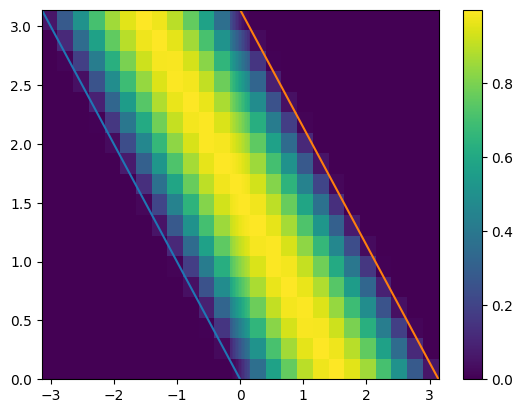

In [8]:
phi_edges_mesh, arm_edges_mesh, az_edges_mesh = np.meshgrid(phi_axis.edges, arm_axis.edges, az_axis.edges, indexing = 'ij')

phase_space_rsp = phi_arm_az_phase_space(phi_edges_mesh[:-1, :-1, :-1], 
                                  phi_edges_mesh[ 1:, :-1, :-1], 
                                  arm_edges_mesh[:-1, :-1, :-1],
                                  arm_edges_mesh[:-1, 1:,  :-1:],
                                   az_edges_mesh[:-1, :-1, :-1],
                                   az_edges_mesh[:-1, :-1,  1:])

h_ps = Histogram([arm_axis, phi_axis], contents = np.sum(phase_space_rsp, axis = 2).transpose())

bin_area = ((phi_edges_mesh[1:,  :-1, :-1]  - phi_edges_mesh[:-1, :-1, :-1]) * 
            (arm_edges_mesh[:-1, 1:,  :-1:] - arm_edges_mesh[:-1, :-1, :-1]) * 
             (az_edges_mesh[:-1, :-1,  1:]  -  az_edges_mesh[:-1, :-1, :-1]))

h_ps_diff = h_ps / np.sum(bin_area, axis = 2).transpose() # Phase space per bin area, for nicer visualization

ax,plot = h_ps_diff.plot()

x = np.linspace(-np.pi, np.pi, 100)
ax.plot(x, -x)
ax.plot(x, np.pi-x)

ax.set_ylim(0,np.pi)

# Should be 2*np.pi = 6.283185307179586 (az area = 2*pi, phi area = pi, and phi+arm (psichi radius) area = 2)
np.sum(h_ps/2/np.pi)

int_prob_phi_arm_az_matrix is what you would obtain from MEGAlib, and you would need to _divide_ it by the phase space

In [9]:



# Normalized to 1 for each direction (i.e. each bin of the measured axes)
int_prob_phi_arm_az_matrix = (prob_phi_arm_az_matrix * phase_space_rsp[None]).project(0).contents
print(np.min(int_prob_phi_arm_az_matrix), np.max(int_prob_phi_arm_az_matrix))

0.9982617109507523 0.9982617109507523


### Background simulations

#### Bkg events generator

In [10]:
max_phi_bkg = 0.3  # Makes it inconsistent with any possible source. You can change it back to np.pi, but the bkg events end up being mimicked by a nunch of random small sources

def random_bkg_event(nevents):
    
    # Isotropic in psichi
    # Adjust representation to match random_event()
    psichi = SkyCoord(np.random.uniform(-1, 1, size = (nevents, 3)), 
                      representation_type = 'cartesian', frame = SpacecraftFrame())
    psichi = SkyCoord(psichi.represent_as('unitspherical'),
                      representation_type = 'unitspherical',
                      frame = SpacecraftFrame())
    
    # Flat in phi
    phi = np.random.uniform(0, max_phi_bkg, nevents)
    
    return phi, psichi

#### Bkg model (analytic)

In [11]:
def bkg_dist(phi, psichi):
    """
    Normalized to 1
    """
    

    phi = np.array(phi)
    
    prob = ((phi < max_phi_bkg) * (1/max_phi_bkg)  *      # Flat in phi 
            (1 / 4 / np.pi))  # Isotropic in psichi

    return np.broadcast_to(prob, phi.shape)

#### Bkg model (discretized)

Similar comment about the phase space.

In [12]:
phi_axis = Axis(np.linspace(0,np.pi,18+1))
psichi_axis = HealpixAxis(nside = 8, coordsys = SpacecraftFrame())

phi_centers, psichi_centers = np.meshgrid(phi_axis.centers, 
                                          psichi_axis.pix2skycoord(range(psichi_axis.npix)),
                                           indexing = 'ij')



bkg_model = Histogram([phi_axis, psichi_axis], contents = bkg_dist(phi_centers, psichi_centers))

#### Phase space

In [13]:
phi_area_mesh, psichi_area_mesh = np.meshgrid(phi_axis.widths, 
                                              psichi_axis.pixarea(range(psichi_axis.npix)).to_value(u.sr), 
                                              indexing = 'ij')

phase_space_bkg = phi_area_mesh * psichi_area_mesh

# Should be np.pi*4*np.pi = 39.47841760435743 (phi area = pi, psichi area = 4*pi)
print(np.sum(phase_space_bkg))


# Should be 1
print(np.sum(bkg_model * phase_space_bkg))

39.47841760435744
1.1635528346628867


## Richardson-Lucy deconvolution

Notation 
- model^(t+1)_j = model^(t)_j coeff_j / sum_i response_ij
- coeff_j = sum_i (d_i/expectation_i) response_ij
- expectation_i = sum_j response_ij model_j

d_i is the number of counts in the i-th data bin. Since we are
doing an unbinned analysis, it can only be 1 or 0, so
we end up summing over the events to compute coeff_j.

In the unbinned case, the expectation need to be the _differential_
expectation, that is, number of counts phase space in the CDS.
Note that multiplying all expectation values by a constant does
not affect the analysis, since it just increases the likelihood by a constant.

For the normalization (sum_i response_ij), the integral needs to
include the full data space, that's why we need Aeff in addition to prob_phi_arm_az.

Note about the background:
The RL algorithm is solving a linear set of equations R*x = d, where 
- e is the variables to solve for,
- d is an array of observed data,
- R is the response matrix.

Since the expectation is just signal+bkg, which is also a linear combination,.
instead of fitting the backgroun on every iteration, I just add the background
parameter to x, and extend R with row corresponding to the background model. 

In [14]:
def rl(phi, psichi, 
       source_model, bkg_norm, 
       Aeff = None, prob_phi_arm_az = None, bkg_dist = None,
       response = None, response_norm = None,
       niter = 1):
    """
    Provide either a pre-computed response or (Aeff, prob_phi_arm_az, bkg_dist)

    Outputs: source_model, bkg_norm, response, response_norm
    """

    # Precompute detector response for each event
    if response is None:

        if (Aeff is None or 
            prob_phi_arm_az is None or 
            bkg_dist is None):
            raise ValueError("Provide either a pre-computed (response, response_norm) or (Aeff, prob_phi_arm_az, bkg_dist)")
        
        print("Preparing event response matrix, takes about 1 min...")
        pix_centers = source_model.pix2skycoord(range(source_model.npix)) 
    
        response_norm = np.append(Aeff(pix_centers), 1)
    
        prob_CDS_events = np.append(prob_phi_arm_az_to_CDS(pix_centers, phi, psichi, prob_phi_arm_az), 
                                    bkg_dist(phi, psichi)[None,:], axis = 0)
    
        response = response_norm[:, None] * prob_CDS_events

    if response_norm is None:
        raise ValueError("Provide either a pre-computed (response, response_norm) or (Aeff, prob_phi_arm_az, bkg_dist)")
    
    # Prepare model matrix
    model = np.append(source_model.data, bkg_norm)
    
    # RL iterations
    
    for t in range(niter):

        expectation = np.dot(model, response)

        coeff = np.sum(response / expectation[None,:], axis = 1)  

        model *= coeff / response_norm

        # Logging only
        log_like = -phi.size + np.sum(np.log(expectation))
        tot_expect = np.sum(response_norm * model)
                
        print(f"Iteration: {t}  logLike = {log_like:.2f}  tot_expec = {tot_expect:.2f}/{phi.size}\r", end='')

    if bkg_norm is not None:
        return HealpixMap(base = source_model, data = model[:-1]), model[-1], response, response_norm
    else:
        return HealpixMap(base = source_model, data = model), None, response, response_norm

def prob_phi_arm_az_to_CDS(coord, phi, psichi, prob_phi_arm_az):

   # Convert psichi to az,arm
    sep,az = psichi_to_phiaz(coord, psichi)
    
    # Broadcast
    phi = np.broadcast_to(phi[None,:], sep.shape)

    # Get difference (arm)
    arm = sep - phi

    return prob_phi_arm_az(coord, phi, arm, az)

def log_like(phi, psichi, source_model, bkg_norm, response):
    # Prepare model matrix
    model = source_model.data
    
    if bkg_norm is not None:
        model = np.append(model, bkg_norm)

    expectation = np.dot(model, response)
    
    return -phi.size + np.sum(np.log(expectation))

## Analysis

### Generate random data

In [15]:

# Source 1
flux1 = 1
coord1 = SkyCoord(lon = 45*u.deg, lat = 45*u.deg, frame = SpacecraftFrame())
nevents1 = np.random.poisson(flux1*Aeff(coord1).squeeze())
phi1, psichi1 = random_event(coord1, nevents1)

phi = phi1
psichi = psichi1

# Source 2
flux2 = 3
coord2 = SkyCoord(lon = -30*u.deg, lat = -30*u.deg, frame = SpacecraftFrame())
nevents2 = np.random.poisson(flux2*Aeff(coord2).squeeze())
phi2, psichi2 = random_event(coord2, nevents2)

phi = np.concatenate((phi, phi2))
psichi = skycoord_concatenate([psichi, psichi2])

# Bkg 
nevents_bkg = 100
phi_bkg, psichi_bkg = random_bkg_event(nevents_bkg)

phi = np.concatenate((phi, phi_bkg))
psichi = skycoord_concatenate([psichi, psichi_bkg])

Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform from ICRS


(<AxesSubplot: xlabel='phi'>, <ErrorbarContainer object of 3 artists>)

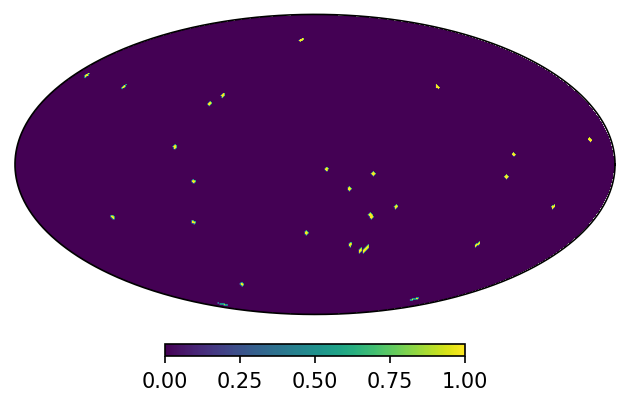

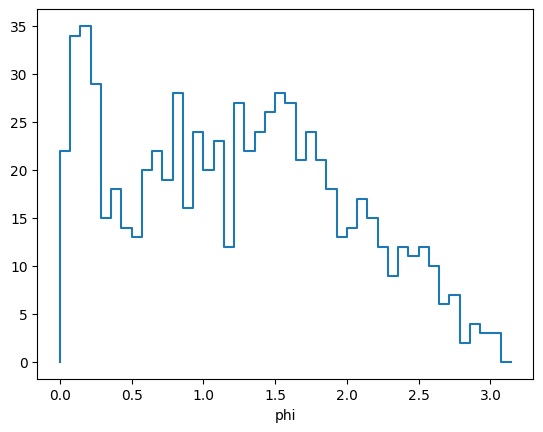

In [16]:
# Bin only for plotting purposes

m = Histogram([Axis(np.linspace(0,np.pi,45), label = 'phi'), 
                    HealpixAxis(nside = 32, coordsys = SpacecraftFrame(), label = 'psichi')])

m.fill(phi, psichi)

m.slice[3].project('psichi').plot()

m.project('phi').plot()

### Run RL

Initialize model.

Note that the binning of the source model is decoupled from the binning of the response. I'm choosing something a few times smaller than the angular resolution

In [17]:
source_model = HealpixMap(nside = 64, coordsys = SpacecraftFrame())
source_model[:] = 1
bkg_norm = 1

Set the effective area, CDS differential probability and background model.

The following block is just the 0th-order or linear interpolations of the matrices created above

In [18]:
Aeff_fun = lambda coord: Aeff_matrix.interp(coord)
bkg_dist_fun = lambda phi, psichi: bkg_model[bkg_model.find_bin(phi, psichi)]
prob_phi_arm_az_fun = lambda coord, phi, arm, az: prob_phi_arm_az_matrix[prob_phi_arm_az_matrix.find_bin(np.broadcast_to(coord[:,None], phi.shape), phi, arm, az)]

This uses the exact functions (no discretization) used to generate the matrixes. It's somewhat faster but give consistent results

In [19]:
# Aeff_fun = Aeff
# prob_phi_arm_az_fun = prob_phi_arm_az
# bkg_dist_fun = bkg_dist

In [20]:
source_model, bkg_norm, response, response_norm = rl(phi, psichi,             # data
                                                     source_model, bkg_norm,  # guess
                                                     Aeff = Aeff_fun, prob_phi_arm_az = prob_phi_arm_az_fun, bkg_dist = bkg_dist_fun,   # response
                                                     niter = 50)

Preparing event response matrix, takes about 1 min...


Run more iteration with pre-computed response
You can run it a few times if the likelihood keep changing 

In [21]:
source_model, bkg_norm, response, response_norm = rl(phi, psichi,             # data
                                                     source_model, bkg_norm,  # guess
                                                     response = response, response_norm = response_norm,  # response
                                                     niter = 50)

Check the results:

Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform from ICRS
Failed to transform from 'spacecraftframe' to 'icrs'. Rasterizing in 'spacecraftframe' frame. ERROR: Spacecraft coordinates need attitude to transform from ICRS


Bkg norm = 98.54328126433809  nevents_bkg = 100
Recovered flux source 1: 1.0483213677906265  Real flux source 1 = 1
Recovered flux source 2: 3.1429562339164314  Real flux source 2 = 3


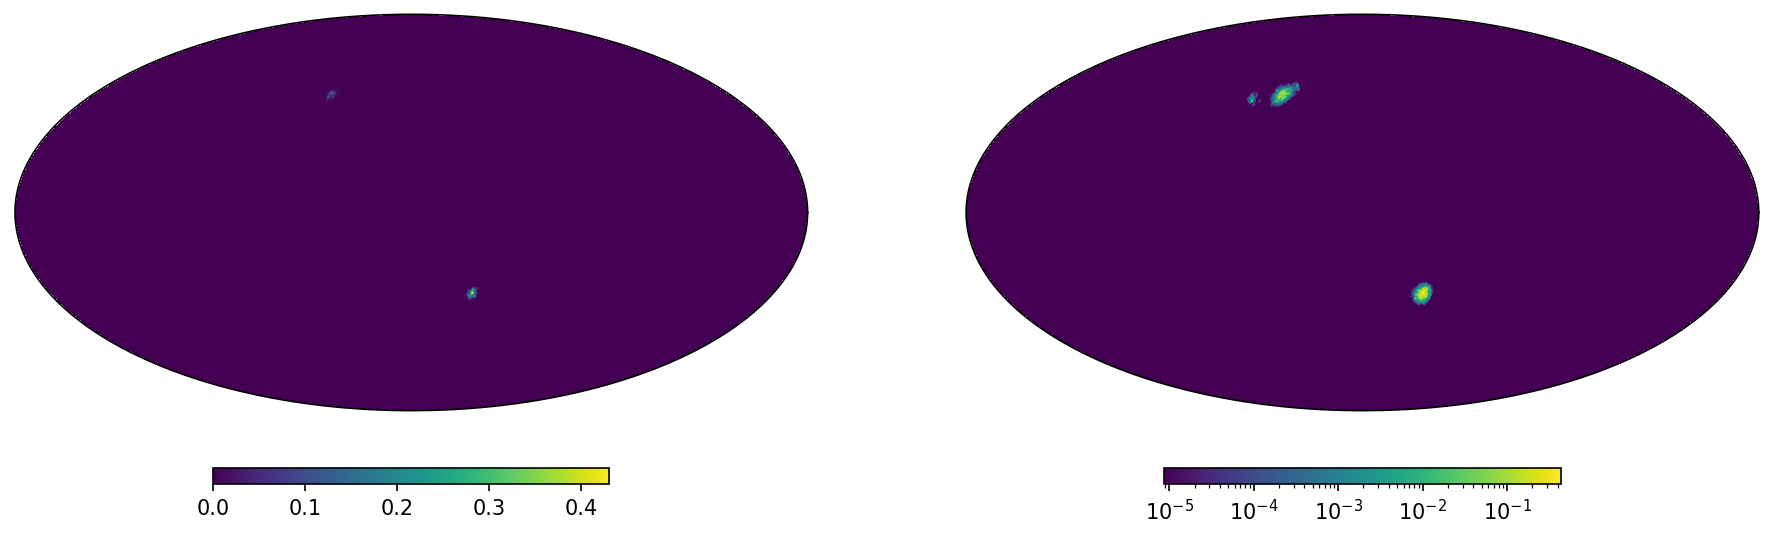

In [22]:


fig,ax = plt.subplots(1,2, subplot_kw = {'projection': 'mollview'}, figsize = [15,10], dpi = 150)

source_model.plot(ax[0])

source_model.plot(ax[1], norm = LogNorm(vmin = np.maximum(1e-10, np.max(source_model))/source_model.npix, # Arb 1e-10 flux in case it's all 0's
                                        vmax = np.maximum(2e-10, np.max(source_model)), 
                                        clip = True))

print(f"Bkg norm = {bkg_norm}  nevents_bkg = {nevents_bkg}")
print(f"Recovered flux source 1: {np.sum(source_model[source_model.query_disc(coord1, 3*angres)])}  Real flux source 1 = {flux1}")
print(f"Recovered flux source 2: {np.sum(source_model[source_model.query_disc(coord2, 3*angres)])}  Real flux source 2 = {flux2}")